# Set up JRA wind anomaly files for easterly perturbation simulations
This notebook creates the forcing files that were used for the easterly perturbations.

First it creates a region mask to separate out the easterlies using the dividing line between the annual average easterly and westerly winds from the JRA55-9091 winds. This is done by selecting a line following the minimum in the absolute value of the annual average wind speed.

Then, using this mask, we add/subtract 10% of the rolling monthly mean u and v wind velocities to the original JRA55 u and v winds. By using the rolling monthly mean, we ensure that we're not amplifying the storm activity, and also minimising change to the seasonal cycle. For example, the easterlies in the control are strong in winter and weak in summer, so if we were to add/subtract a constant fraction of the annual wind speed (rather than monthly wind as we do here), we would inadvertently be overly strengthening the summer winds compared to the winter winds.

We chose to perturb both the u and v components of the wind speed, because in many places the wind follows the topography of the Antarctic continent, so the meridional component of the wind is really just a deflection of the easterlies by Antarctic topography. Therefore we thought it seemed to make most sense to change both components.

## To do:
It would be nice to add some zonal average plots of the original and perturbed zonal wind to this notebook. 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import shutil as shutil
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/easterlies/JRA_forcing/'

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39243 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


## Open ocean bathymetry:

In [3]:
# open bathymetry and shift to JRA forcing coordinates:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'

ht = cc.querying.getvar(expt,'ht' , session,n=1)
# find index where xt_ocean>=0 to roll coords:
xt_ocean = ht.xt_ocean
shift_index = np.where(xt_ocean>=0)[0][0]
ht = ht.roll(xt_ocean=-shift_index,roll_coords=True)
# make xt_ocean go from 0 to 360:
shift_xt_ocean = ht.xt_ocean
new_xt_ocean = np.where(shift_xt_ocean<0,shift_xt_ocean+360,shift_xt_ocean)
ht.coords['xt_ocean'] = new_xt_ocean

land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

## Open the JRA9091 wind files:

In [4]:
u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
ds = xr.open_dataset(u_file,decode_times=False)
u = ds.uas_10m
u = u.load()
u_mean = u.mean('time')

v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'
ds = xr.open_dataset(v_file,decode_times=False)
v = ds.vas_10m
v = v.load()
v_mean = v.mean('time')

speed_mean = np.sqrt(u_mean**2+v_mean**2)

## Plot original winds to see what they look like:

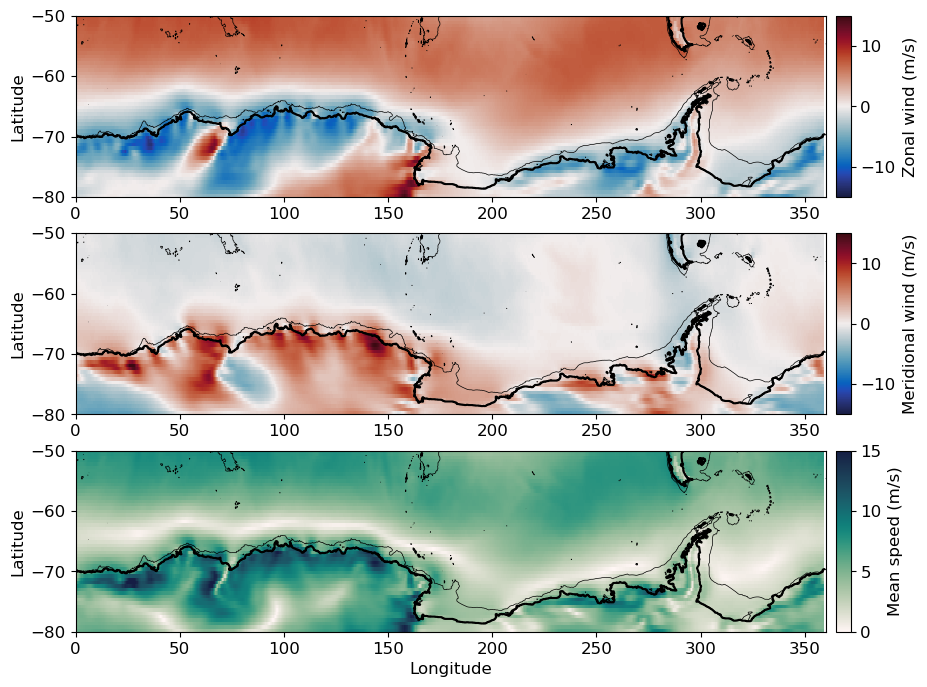

In [10]:
plt.figure(figsize=(10,8))
fontsize=12

scale_max = 15

plt.subplot(3,1,1)
pc = plt.pcolormesh(u.longitude,u.latitude,u_mean,vmin=-scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0.5],colors='k')
plt.ylim(-80,-50)
plt.xlim(0,360)
plt.ylabel('Latitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label('Zonal wind (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
pc = plt.pcolormesh(u.longitude,u.latitude,v_mean,vmin=-scale_max,vmax=scale_max,cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0.5],colors='k')
plt.ylim(-80,-50)
plt.xlim(0,360)
plt.ylabel('Latitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label('Meridional wind (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
pc = plt.pcolormesh(u.longitude,u.latitude,speed_mean,vmin=0,vmax=scale_max,cmap=cmocean.tempo)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0.5],colors='k')
plt.ylim(-80,-50)
plt.xlim(0,360)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label('Mean speed (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

# save:
figure_path = figdir+'RYF_annual_wind_components.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

## Find easterly/westerly dividing line for annual average:
Note that this is similar for each season, so we'll just use the annual average line to mask all times

In [7]:
# mask peninsula to avoid anomalies there:
peninsula_mask = speed_mean.where(speed_mean.latitude<-68).where(speed_mean.longitude>285).where(speed_mean.longitude<296)*0
peninsula_mask = peninsula_mask.fillna(1)
peninsula_mask = peninsula_mask.where(peninsula_mask==1)

latitude = speed_mean.latitude
longitude = speed_mean.longitude

def find_min_lat(var):
    # mask outside of 60 and 80S:
    speed_mask = var.where(var.latitude<-60).where(var.latitude>-80)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim='latitude')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > 4:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(longitude=3,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=2,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=1,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=-1,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=-2,roll_coords=False) +
                                    filtered_min_lat_indices.roll(longitude=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(latitude=smoothed_min_lat_indices.astype(int))
    return smoothed_min_lat

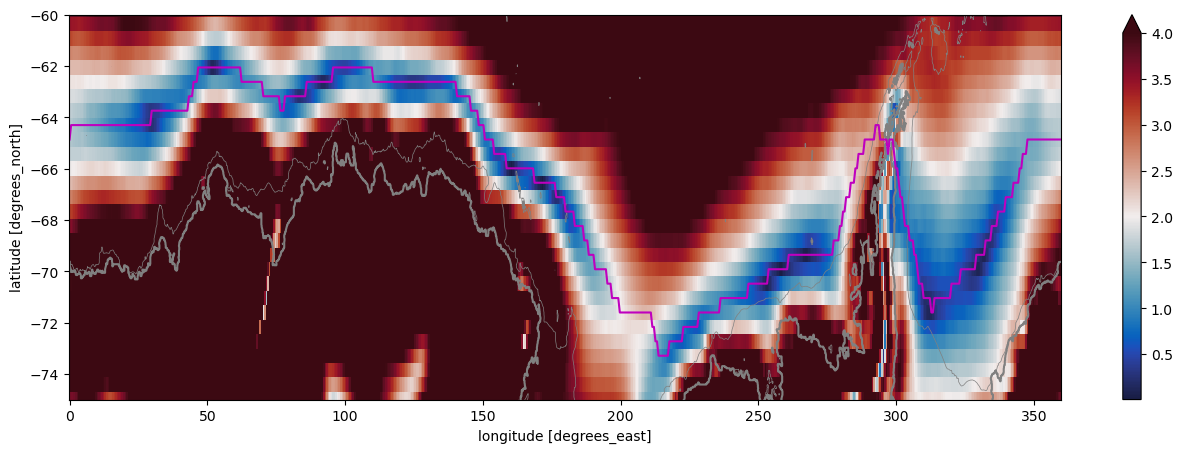

In [10]:
smoothed_min_lat = find_min_lat(speed_mean)

# plot to check:
plt.figure(figsize=(16,5))
speed_mean.plot(cmap=cmocean.balance,vmax=4)
plt.ylim(-75,-60)
plt.plot(longitude,smoothed_min_lat,'m')
# also plot model coastline and 1000m isobath:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='grey')
plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0.5],colors='grey')

## Create mask based on annual dividing line:
This will be equal to 1 in the south where we want to apply the perturbation and 0 to the north, with smoothing between the 2 regions

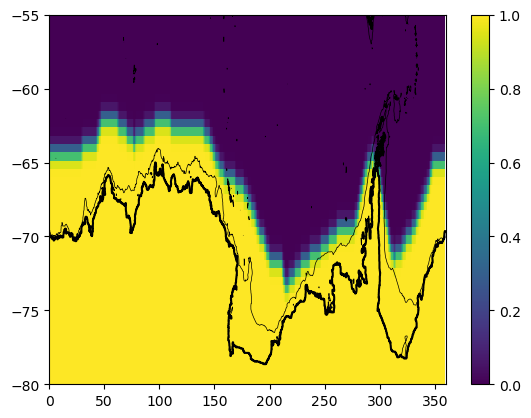

In [13]:
wind_mask = speed_mean*0 + 1
wind_mask = wind_mask.where(latitude<smoothed_min_lat)
wind_mask = wind_mask.fillna(0)

# smooth mask:
wind_mask=scipy.ndimage.gaussian_filter(wind_mask,sigma=1)

plt.pcolormesh(longitude,latitude,wind_mask)
plt.colorbar()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0.5],colors='k')
plt.ylim(-80,-55);

## Now we want to compute the rolling monthly mean, and we will add 10% of this to the original JRA winds

In [14]:
# calculate masked rolling monthly mean to add to existing wind:

# first pad start and end of year, so rolling mean wraps around Dec/Jan division:
u_pad = u.pad(time=15*8, mode='wrap') # pad with 15 days of data to allow for monthly averages
v_pad = v.pad(time=15*8, mode='wrap') # pad with 15 days of data to allow for monthly averages

# compute rolling mean using a 30 day window:
u_monthly_mean = u_pad.rolling(time=8*30,center=True).mean().dropna('time')
v_monthly_mean = v_pad.rolling(time=8*30,center=True).mean().dropna('time')

# this somehow ends up with 1 timestep too many, drop last time index to fix:
u_monthly_mean = u_monthly_mean[:-1,:,:]
v_monthly_mean = v_monthly_mean[:-1,:,:]

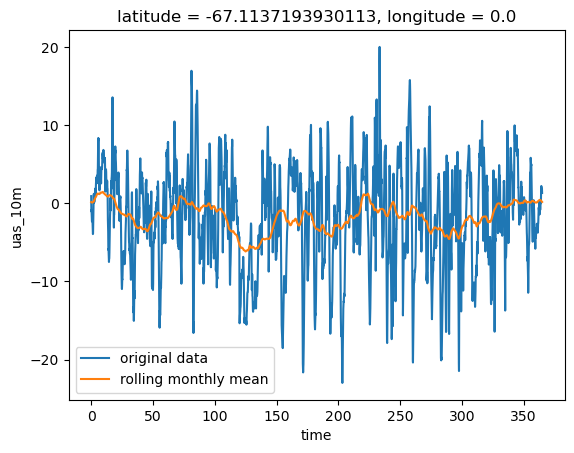

In [15]:
# check it looks sensible for sample location:
u[:,40,0].plot(label='original data')
u_monthly_mean[:,40,0].plot(label='rolling monthly mean')
plt.legend()

## Save 10% wind speed addition and total new wind speed to files

In [ ]:
'''# to ensure metadata etc is correct, copy old files and overwrite data:

# original files:
#u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
#v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'

###### Save wind anomalies if using Nic's method to add/subtract from original forcing:
u_addition = 0.1*wind_mask*u_monthly_mean
v_addition = 0.1*wind_mask*v_monthly_mean
# new file names:
new_u_file = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_anomaly.u_10.1990_1991.nc'
new_v_file = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_anomaly.v_10.1990_1991.nc'
# copy old files into new file paths:
shutil.copyfile(u_file,new_u_file)
shutil.copyfile(v_file,new_v_file)
# then overwrite the variables in the new files with the new data:
ncFile = nc.Dataset(new_u_file,'r+')
ncFile.variables['uas_10m'][...] = u_addition.values
ncFile.close()
ncFile = nc.Dataset(new_v_file,'r+')
ncFile.variables['vas_10m'][...] = v_addition.values
ncFile.close()

###### Also save complete files needed for increase perturbations runs without Nic's method:
u_increased = u + u_addition
v_increased = v + v_addition
# new file names:
new_u_file = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_increased10.u_10.1990_1991.nc'
new_v_file = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_increased10.v_10.1990_1991.nc'
# copy old files into new file paths:
shutil.copyfile(u_file,new_u_file)
shutil.copyfile(v_file,new_v_file)
# then overwrite the variables in the new files with the new data:
ncFile = nc.Dataset(new_u_file,'r+')
ncFile.variables['uas_10m'][...] = u_increased.values
ncFile.close()
ncFile = nc.Dataset(new_v_file,'r+')
ncFile.variables['vas_10m'][...] = v_increased.values
ncFile.close()

###### Also save complete files needed for decrease perturbations runs without Nic's method:
u_decreased = u - u_addition
v_decreased = v - v_addition
# new file names:
new_u_file = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_decreased10.u_10.1990_1991.nc'
new_v_file = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v13_ryf9091_easterlies/RYF_easterlies_decreased10.v_10.1990_1991.nc'
# copy old files into new file paths:
shutil.copyfile(u_file,new_u_file)
shutil.copyfile(v_file,new_v_file)
# then overwrite the variables in the new files with the new data:
ncFile = nc.Dataset(new_u_file,'r+')
ncFile.variables['uas_10m'][...] = u_decreased.values
ncFile.close()
ncFile = nc.Dataset(new_v_file,'r+')
ncFile.variables['vas_10m'][...] = v_decreased.values
ncFile.close()'''

## How large are zonal winds relative to the meridional winds?

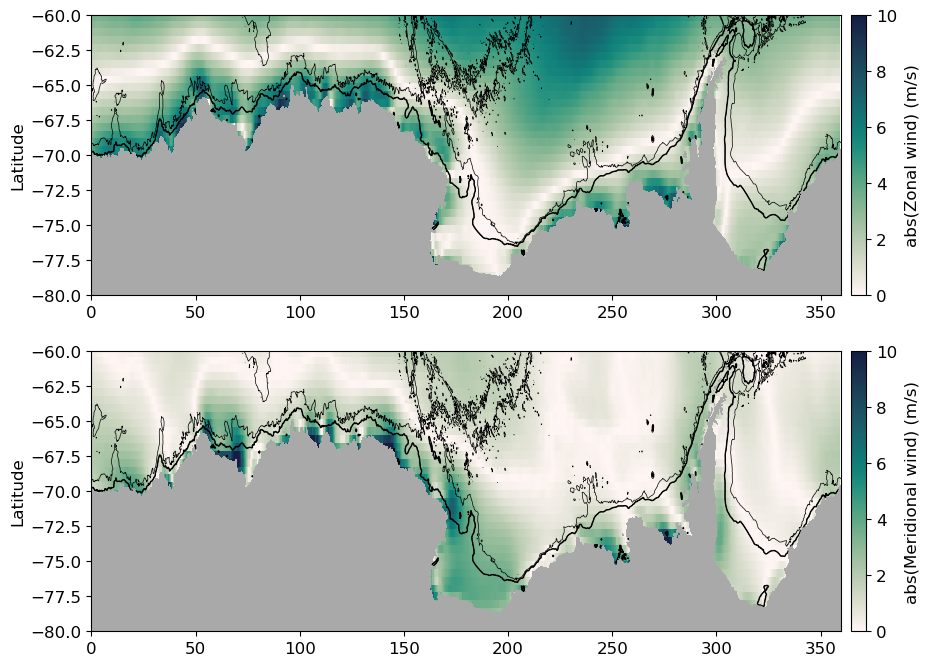

In [10]:
plt.figure(figsize=(10,8))
fontsize=12

scale_max = 10

plt.subplot(2,1,1)
pc = plt.pcolormesh(u.longitude,u.latitude,np.abs(u_mean),vmin=0,vmax=scale_max,cmap=cmocean.tempo)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0.5],colors='k')
plt.ylim(-80,-60)
plt.xlim(0,360)
plt.ylabel('Latitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[3000],colors='k',linewidths=0.5)
#plt.title('Bottom temperature, easterlies increase anomaly',fontsize=fontsize)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask_masked,colors='darkgrey',zorder=2)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label('abs(Zonal wind) (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(2,1,2)
pc = plt.pcolormesh(u.longitude,u.latitude,np.abs(v_mean),vmin=0,vmax=scale_max,cmap=cmocean.tempo)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[3000],colors='k',linewidths=0.5)
#plt.title('Bottom temperature, easterlies increase anomaly',fontsize=fontsize)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask_masked,colors='darkgrey',zorder=2)

plt.ylim(-80,-60)
plt.xlim(0,360)
plt.ylabel('Latitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0.5],colors='k')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label('abs(Meridional wind) (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [70]:
# Compute the ratio of winds. This is positive when the zonal winds > meridional winds, and negative when meridional winds are largest.

ratio_u = np.abs(u_mean)/np.abs(v_mean)
ratio_v = -np.abs(v_mean)/np.abs(u_mean)
ratio = ratio_u.where(ratio_u>1,other=ratio_v)

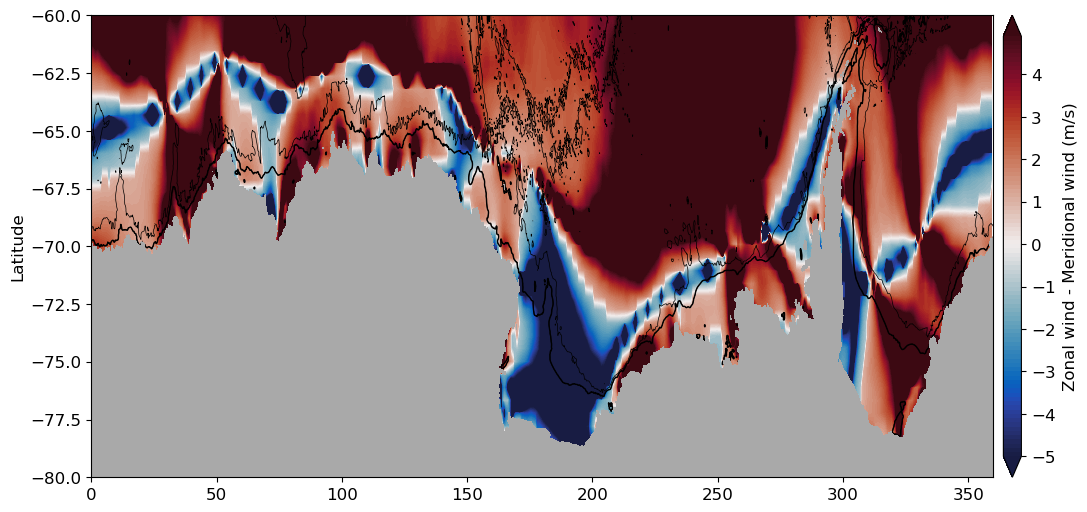

In [93]:
plt.figure(figsize=(12,6))
fontsize=12

norm = col.Normalize(vmin=-5,vmax=5)
levels=np.arange(-5,5,.1)

pc = plt.contourf(u.longitude,u.latitude,ratio,norm = norm,levels=levels,extend='both',cmap=cmocean.balance)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contour(ht.xt_ocean,ht.yt_ocean,land_mask,levels=[0.5],colors='k')
plt.ylim(-80,-60)
plt.xlim(0,360)
plt.ylabel('Latitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=1)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[3000],colors='k',linewidths=0.5)
#plt.title('Bottom temperature, easterlies increase anomaly',fontsize=fontsize)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask_masked,colors='darkgrey',zorder=2)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label('Zonal wind - Meridional wind (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
